# **PHYS 449: Final Project Notebook**
#### Reproducing results from "Morphological classification of galaxies with deep learning: comparing 3-way and 4-way CNNs" by Mitchell K. Cavanagh, Kenji Bekki and Brent A. Groves

*This all just assumed 4-way classification for now

# **Set Current Working Directory**

For example, for Ashley this is:

'/content/drive/MyDrive/Fall 2022/PHYS 449/Final Project'

In [2]:
CWD = '/content/drive/MyDrive/Fall 2022/PHYS 449/Final Project/'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Packages**

Begin by importing all the needed packages

In [4]:
# if you've never used w&b before you need to run these commands, if this gives you issues just comment out w&b stuff for now
#! pip install wandb
#import wandb
#wandb.login()

In [5]:
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Flatten, Conv2D, MaxPool2D
from keras.layers.core import Dropout
import os

In [30]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
import re

#DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

# connect to w&b for experiment tracking
#wandb.init(project="CNN-4way-C1-subset", entity="449-final project")

# **Define Network Structure**
We are considering two 2D CNNs, C1 and C2, which are described in the paper and outlined below

In [38]:
# need to double check but this is roughly right
networkc1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=0),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0),
    nn.ReLU(),
    # max pool here
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(1600, 256), 
    # dropout here
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(256,4))

# **Load Data**

In [8]:
#Import google drive (need to put data folder as shortcut in your local drive My Drive):
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
#LOAD THE DATA FROM TXT FILE INTO A BATCH:
def data_batch(datafile_index, num_images=10, data_file=CWD+'/data/data_g_band.txt', plotting=False):
    '''
    Description:
        Access datafile.txt, each row is flattened 110x110 image + 1 label string (E, Sp, S0, Irr+Misc).
        Returns an augmented batch of num_images X 40.
        The labels are converted to 1D vectors (ex: Sp = [0,0,1,0])
        Need to give a datafile_index that tells which rows to pick.
    Inputs:
        datafile_index: index of row in datafile to load. loads rows datafile_index to datafile_index+num_images.
        num_images: number of different images to load per batch, total batch size 
        is 40 X num_images. (default: 10 (for 40X10 = 400 batch size like in paper)
        data_file: datafile full path, need to add shortcut to local Drive. (default: '/content/drive/MyDrive/data/data_g_band.txt')
    Outputs:
        tensor_input_batch_aug: dimensions: (100, 100, num_images X 40). 
        tensor_label_batch_aug: dimensions: (num_images X 40, 4)
    '''

    #Take batch of num_images rows from datafile:
    with open(data_file, 'r') as f:
        rows = f.readlines()[datafile_index:(datafile_index+num_images)]

    #for batch size of 400 (augmented), need 10 images
    data_batch = np.zeros((num_images,12101), dtype=np.dtype('U10'))
    count = 0
    for row in rows:
        data_batch[count,:] = row.split()
        count += 1

    #separate label and input:
    input_batch_flat = np.array(data_batch[:,:12100], dtype=float)#, dtype=int)
    label_batch = np.array(data_batch[:,-1])

    #convert input batch back to a 2D array:
    input_batch = np.zeros((110,110,np.shape(input_batch_flat)[0]))#, dtype=int)
    for ii in range(np.shape(input_batch_flat)[0]):
        input_batch[:,:,ii] = np.reshape(input_batch_flat[ii,:], (110,110))


    #convert label batch into into 1D vector: 
    #E=0, S0=1, Sp=2, Irr+Misc=3
    #ex: label = [0,0,1,0] ==> Sp galagy
    arr_label_batch = np.zeros((np.shape(label_batch)[0],4), dtype=int)
    arr_label_batch[:,0] = np.array([label_batch == 'E'], dtype=int)
    arr_label_batch[:,1] = np.array([label_batch == 'Sp'], dtype=int)
    arr_label_batch[:,2] = np.array([label_batch == 'S0'], dtype=int)
    arr_label_batch[:,3] = np.array([label_batch == 'Irr+Misc'], dtype=int)

    if plotting == True:
      #test with image plotted
      plt.imshow(input_batch[:,:,0])
      plt.show()

    #NOW AUGMENT THE BATCH (40X more):
    input_batch_aug = np.empty((100,100,np.shape(input_batch)[2]*40), dtype=int)
    arr_label_batch_aug = np.empty((np.shape(arr_label_batch)[0]*40, 4), dtype=int)

    count = 0
    for ll in range(np.shape(input_batch)[2]):
        #Crop 5X more image (100X100 pixels)
        C1 = input_batch[:100,:100,ll]
        C2 = input_batch[10:,:100,ll]
        C3 = input_batch[:100,10:,ll]
        C4 = input_batch[10:,10:,ll]
        C5 = input_batch[5:105,5:105,ll]

        C = [C1, C2, C3, C4, C5]

        for kk in range(5):
            #Rotate 4X more image (by 90 deg)
            for jj in range(4):
                C_R = np.rot90(C[kk], k=jj)
                input_batch_aug[:,:,count] = C_R
                arr_label_batch_aug[count,:] = arr_label_batch[ll,:]
                count += 1
                
                input_batch_aug[:,:,count] = np.swapaxes(C_R,0,1)
                arr_label_batch_aug[count,:] = arr_label_batch[ll,:]
                count += 1


    #PUT THE DATA AS A PYTORCH TENSOR:
    tensor_input_batch_aug = torch.Tensor(input_batch_aug)
    tensor_label_batch_aug = torch.Tensor(arr_label_batch_aug)
    
    return tensor_input_batch_aug, tensor_label_batch_aug


280


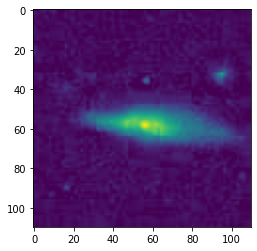

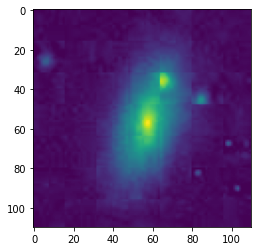

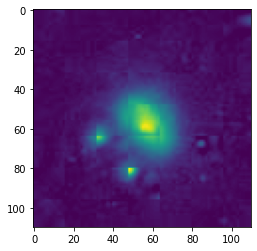

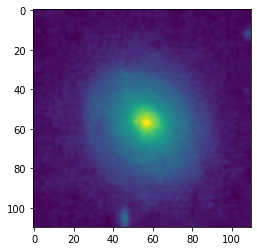

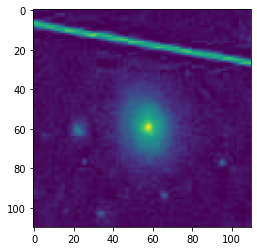

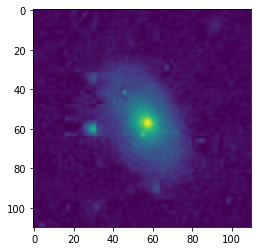

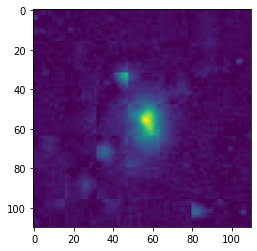

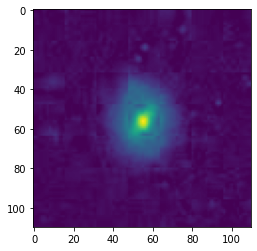

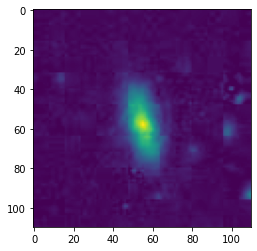

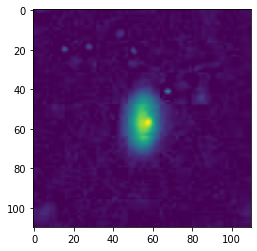

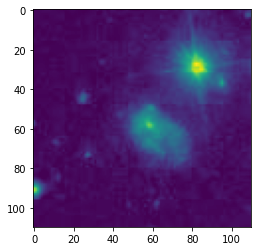

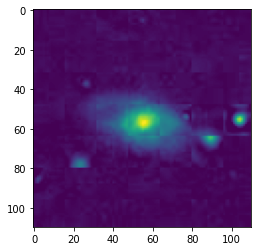

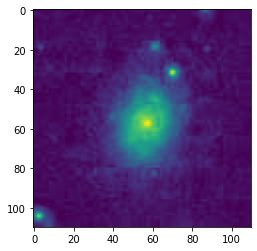

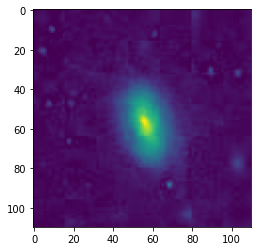

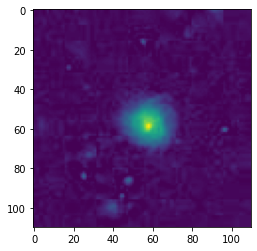

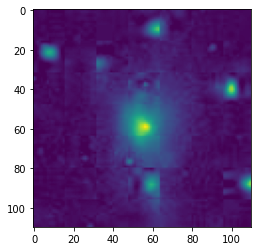

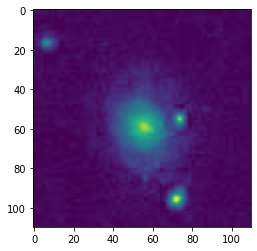

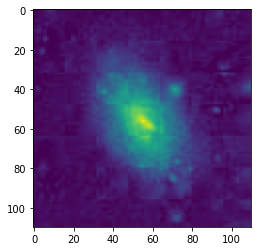

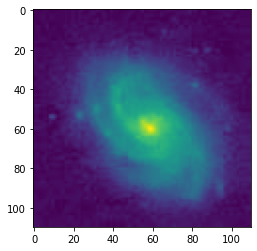

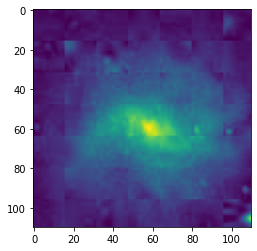

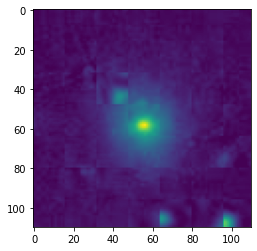

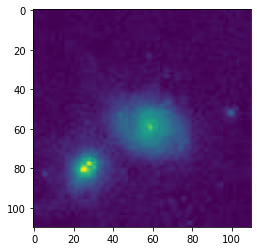

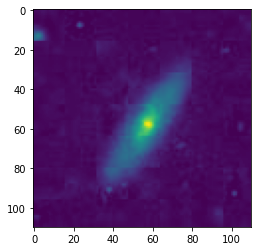

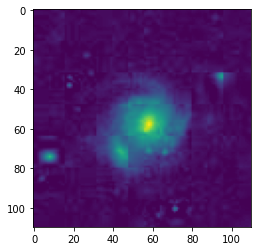

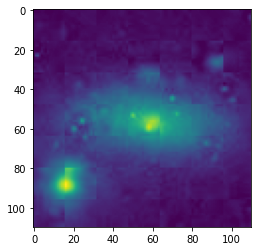

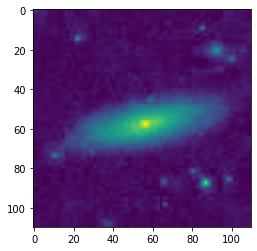

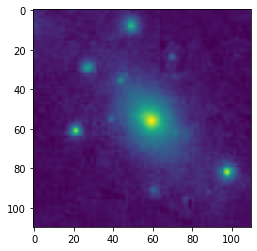

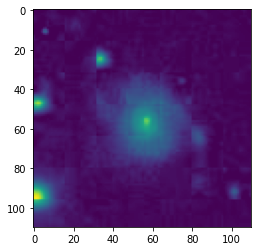

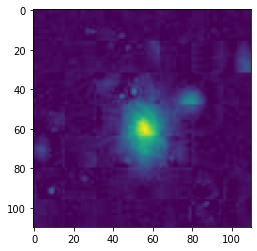

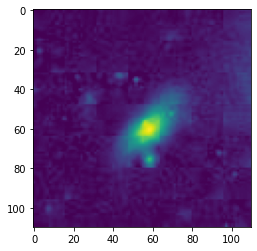

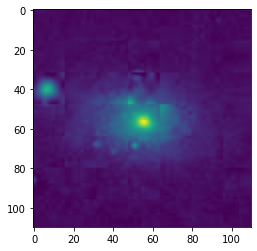

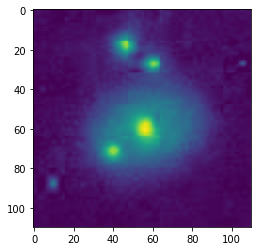

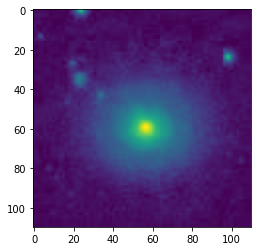

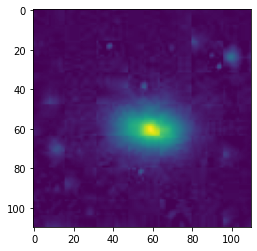

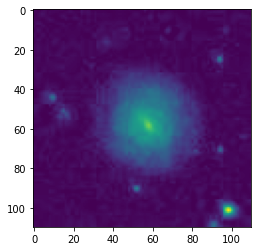

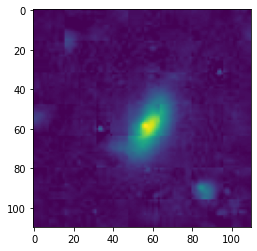

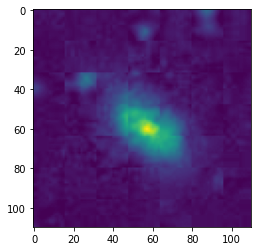

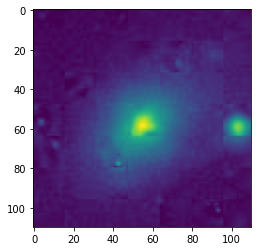

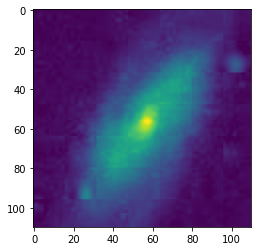

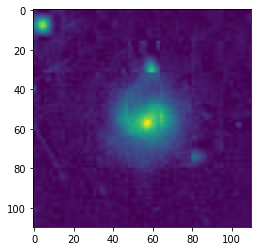

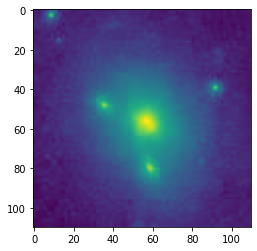

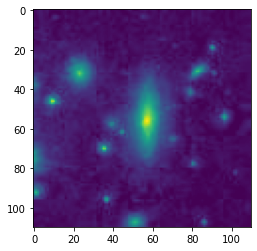

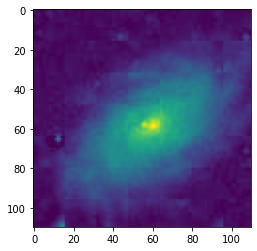

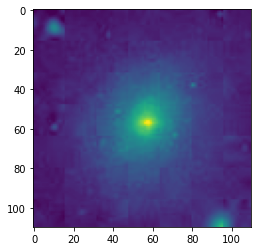

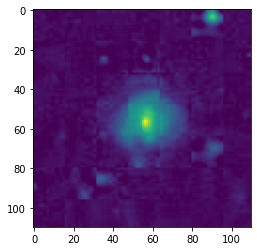

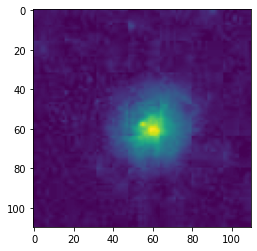

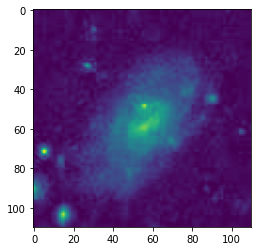

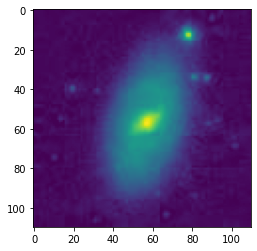

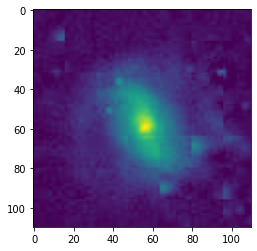

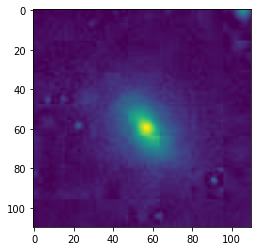

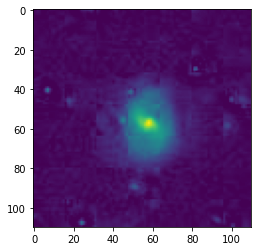

KeyboardInterrupt: ignored

In [33]:
# ashley's troubleshooting
rand_index = np.random.permutation(280)

print(np.shape(rand_index)[0])

#Use this loop for training over entire dataset at each epochs
for ii in range(np.shape(rand_index)[0]):
  image_batch, label_batch = data_batch(datafile_index=50*rand_index[ii], num_images=50)
  #print(np.shape(image_batch), np.shape(label_batch))
  #print(ii)

# **Sample Data**
Here we check that the data files are how we expect them to be

In [ ]:
# can just call data load for some if we made plotting an optional arg
rand_index = np.random.permutation(10)
print(np.shape(rand_index)[0])
for ii in range(np.shape(rand_index)[0]):
  image_batch, label_batch = data_batch(datafile_index=50*rand_index[ii], num_images=50, plotting = True)

# **Split Data**
Here we split data into trainng, testing datasets (validation split will be done by keras during training)

In [10]:
#Train and test set
rand_index = np.random.permutation(1403)
rand_train = rand_index[:1300] # get these split like paper proportions
rand_test = rand_index[1300:1403] # valudation will be taken from test set

# **Training**
Ideally we use seperate notebooks to train each one

C2 uses Adam, wheras C1 uses Adadelta: 

  https://www.aanda.org/articles/aa/full_html/2020/09/aa37963-20/aa37963-20.html


In [11]:
network_to_train = 'C1'

# define hyperparameters of training
if network_to_train == 'C1':
  n_epochs = 12
  # can't find learning rate mentioned so I'm leaving it as default for now
  cn_model = networkc1
  optimizer = torch.optim.Adadelta(cn_model.parameters()), lr=2e-4)

##### C2 HAS NOT BEEN IMPLIMENTED YET IN PYTORCH VERSION 
'''
elif network_to_train == 'C2':
  n_epochs = 20
  lr = 2*pow(10,-4)
  opt = keras.optimizers.Adam(learning_rate=lr)
  cn_model = networkc2
'''

"\nelif network_to_train == 'C2':\n  n_epochs = 20\n  lr = 2*pow(10,-4)\n  opt = keras.optimizers.Adam(learning_rate=lr)\n  cn_model = networkc2\n"

In [ ]:
# train in pytorch loop 
loss_fn = torch.nn.CrossEntropyLoss() 

# Initialize network & move to GPU
#cn_model.to(DEVICE)  # comment out if this gives you issues

# For monitoring acc and losses
avg_epoch_acc_train = []
avg_epoch_acc_val = []
avg_epoch_losses_train = []
avg_epoch_losses_val = []

num_images = 10
batch_size = num_images*40 

print('Model initialized and prepped, begin training...')
cn_model.train()
for epoch in range(n_epochs):  
    print('epoch:', epoch+1)

    # quick fix to get dataset size
    ds_size = 0

    t_acc_lst = []
    epoch_loss = 0
    for ii in range(np.shape(rand_index)[0]): 
      #print('batch', ii+1, '/', batch_size)
      im, y = data_batch(datafile_index=num_images*rand_train[ii], num_images=num_images)

      # reshaping im to what we want (can do this as data output too)
      im = im.reshape(im.shape[2], 1, 100, 100)

      y_pred = cn_model(im)
      y_pred_cat = nn.functional.softmax(y_pred, dim=1)
      
      ### VERY TEMPORARY WAY OF GETTING ESTIMATE ON ACCURACIES (avg accross all 4)
      ### we want to only make one class prediction by picking max, my brain just isnt working
      ### this is an overestimate since like if it predicts 0 for all it gets 75%
      ### so this is a very strong OVERESTIMATION of accuracy
      y_pred_class = y_pred_cat 
      y_pred_class[y_pred_class >= 0.5] = 1
      y_pred_class[y_pred_class < 0.5] = 0
      t_acc_batch = torch.sum(y_pred_class == y).numpy()/(4*batch_size) 

      t_acc_lst.append(t_acc_batch)

      loss = loss_fn(y_pred, y)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      ds_size += 1

    t_loss = epoch_loss / ds_size
    print('training loss:', t_loss)
    avg_epoch_losses_train.append(t_loss)

    t_acc = sum(t_acc_lst)/len(t_acc_lst) 
    print('training accuracy:', t_acc)
    avg_epoch_acc_train.append(t_acc)

    # Validation
    cn_model.eval()
    epoch_loss = 0
    with torch.no_grad():
      ## quick fix to get some validation data, we want to use more than this 
      for ii in range(np.shape(rand_test)[0]):
        if ii == 0:
          im_valid, y_valid = data_batch(datafile_index=num_images*rand_test[ii], num_images=num_images)
          im_valid = im_valid.reshape(im_valid.shape[2], 1, 100, 100)
        else:
          break
      y_pred_valid = cn_model(im_valid)
      loss = loss_fn(y_pred_valid, y_valid)
      epoch_loss += loss.item()
      v_loss = epoch_loss
      avg_epoch_losses_val.append(v_loss)
      print('validation loss:', v_loss)

      y_pred_valid_cat = nn.functional.softmax(y_pred_valid, dim=1)
      y_pred_valid_cat[y_pred_valid_cat >= 0.5] = 1
      y_pred_valid_cat[y_pred_valid_cat < 0.5] = 0
      v_acc = torch.sum(y_pred_valid_cat == y_valid).numpy()/(4*batch_size) # change these 4s if we go to 3-way
      print('validation accuracy:', v_acc)
      avg_epoch_acc_val.append(v_acc)


      #wandb.log({"loss": loss, "validation_loss": v_loss})
      #wandb.watch(cn_model)

Model initialized and prepped, begin training...
epoch: 1
training loss: 1.1477987402251788
training accuracy: 0.7689285714285721
validation loss: 0.9465113878250122
validation accuracy: 0.75
epoch: 2
training loss: 1.1241188004612923
training accuracy: 0.7721428571428579
validation loss: 0.797087550163269
validation accuracy: 0.8
epoch: 3
training loss: 1.1407751985958645
training accuracy: 0.7678571428571433
validation loss: 0.8989355564117432
validation accuracy: 0.75
epoch: 4


Ashley's troubleshooting notes:
- I actually run into the issue again when I try num_images = 50, but num_images = 10 seems to be totally fine
- I thought the issue was due to us using empty in the data loading function and it using old memory so I did make some changes in that function like replacing that with zeros
- C1 might not be working due to different stride and no set learning rate

In [ ]:
# save model itself 
torch.save(cn_model.state_dict(), 'test_model1')#, CWD + 'Notebooks/models/')

In [ ]:
# plot accuracy/loss versus epoch
fig1 = plt.figure(figsize=(10,3))


ax1 = plt.subplot(121)
ax1.plot(avg_epoch_acc_train, '--', color='darkslategray', linewidth=2, label='training')
ax1.plot(avg_epoch_acc_val, linewidth=2, label='valiation') 
ax1.legend()
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')

ax2 = plt.subplot(122)
ax2.plot(avg_epoch_losses_train, '--', color='crimson', linewidth=2, label='training')
ax2.plot(avg_epoch_losses_val, linewidth=2, label='validation')
ax2.legend()
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')

fig1.savefig(CWD + 'Notebooks/plots/'+'CNN_training_history.png')

plt.show()

# **Testing - Don't run this yet, it's not done **
Here we apply the model to the test set and create a confusion matrix to gauge performance

In [ ]:
#@title
### ADAPT THIS TO GET TEST SET STATS (way to make it not do data augmentation and just stick with original images?)
for ii in range(np.shape(rand_test)[0]):
  if ii == 0:
    pass
  else:
    image_batch, label_batch = data_batch(datafile_index=50*rand_test[ii], num_images=50)

In [ ]:
#@title
# make predictions on test set and compare to real labels
preds_test = cn_model.predict(X_test, verbose=1)
results = cn_model.evaluate(X_test, y_test) 
print("test loss, valid acc:", results)

In [ ]:
#@title
# plot confusion matrix
fig2 = plt.figure()
cm = confusion_matrix(y_valid, preds_valid)
plt.matshow(cm)

for (i, j), z in np.ndenumerate(cm):
    pyl.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.title('Confusion matrix (validation data)')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
plt.savefig(model_dir_name +'plots/'+'CNN_confusion_matrix.png')